# Knowledge Graph Data EDA

In [ ]:
%pip install neo4j pandas matplotlib seaborn graph graphdatascience

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement graph (from versions: none)
ERROR: No matching distribution found for graph


In [1]:
# Install the official driver if not installed
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

if os.getenv("red_eye_state", "development") == "development":
    from dotenv import load_dotenv
    load_dotenv()

uri = os.getenv("NEO4J_URI")
user = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(uri, auth=(user, password))


In [2]:
def cypher(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.data() for r in result])

In [5]:
cypher("""
MATCH (u:User) RETURN count(u) AS users
""")

,users
0,0


In [ ]:
cypher("""
MATCH (e:Event) RETURN count(e) AS events
""")


,TO
0,589085


In [7]:
cypher("""
MATCH (:User)-[r:ATTENDED]->(:Event) RETURN count(r) AS attended_rels
""")


,attended_rels
0,4688169


In [8]:
user_degree = cypher("""
MATCH (u:User)-[:ATTENDED]->(e:Event)
RETURN u.id AS user, count(e) AS events_attended
ORDER BY events_attended DESC
""")

user_degree.head()


,user,events_attended
0,82351,10434
1,135593,10012
2,597492,9330
3,901191,7812
4,665823,7576


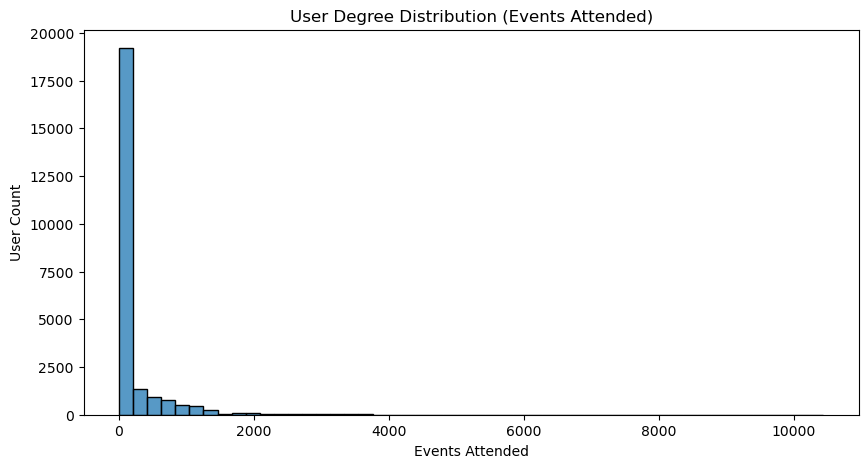

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(user_degree["events_attended"], bins=50)
plt.title("User Degree Distribution (Events Attended)")
plt.xlabel("Events Attended")
plt.ylabel("User Count")
plt.show()

### Event Popularity Distribution

In [10]:
event_popularity = cypher("""
MATCH (u:User)-[:ATTENDED]->(e:Event)
RETURN e.id AS event, count(u) AS attendees
ORDER BY attendees DESC
""")

event_popularity.head()


,event,attendees
0,1000000189,1291273
1,1000000049,1127622
2,1000001146,857022
3,1000003684,373356
4,1000001148,317833


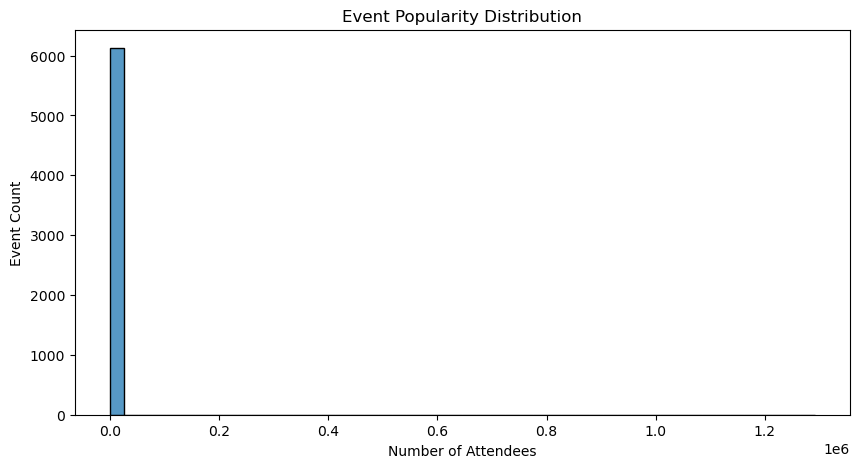

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(event_popularity["attendees"], bins=50)
plt.title("Event Popularity Distribution")
plt.xlabel("Number of Attendees")
plt.ylabel("Event Count")
plt.show()


#### User to User relations

In [12]:
cypher("""
MATCH (:User)-[:ATTENDED]-(:User)
RETURN count(*) AS invalid_user_to_user
""")

,invalid_user_to_user
0,0


#### Event to Event relations

In [13]:
cypher("""
MATCH (:Event)-[:ATTENDED]-(:Event)
RETURN count(*) AS invalid_event_to_event
""")

,invalid_event_to_event
0,0


#### Return most Attending users

In [14]:
cypher("""
MATCH (u:User)-[:ATTENDED]->(e:Event)
RETURN u.id AS user, count(e) AS events_attended
ORDER BY events_attended DESC
LIMIT 10
""")


,user,events_attended
0,82351,10434
1,135593,10012
2,597492,9330
3,901191,7812
4,665823,7576
5,237781,6700
6,1764596,6694
7,584631,6550
8,111471,6427
9,38714,6292


#### Most Attended Events

In [15]:
cypher("""
MATCH (u:User)-[:ATTENDED]->(e:Event)
RETURN e.id AS event, count(u) AS attendees
ORDER BY attendees DESC
LIMIT 10
""")

,event,attendees
0,1000000189,1291273
1,1000000049,1127622
2,1000001146,857022
3,1000003684,373356
4,1000001148,317833
5,1000001476,146236
6,1000001439,134025
7,1000001155,66977
8,1000002660,46187
9,1000001925,26344


#### Projection — Create GDS Graph

In [16]:
cypher("""
CALL gds.graph.drop('UserEventGraph', false)
""")

cypher("""
CALL gds.graph.project(
  'UserEventGraph',
  ['User', 'Event'],
  {
    ATTENDED: {
      type: 'ATTENDED',
      orientation: 'UNDIRECTED'
    }
  }
) YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
""")


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 1} for query: "\nCALL gds.graph.drop('UserEventGraph', false)\n"


,graphName,nodeCount,relationshipCount
0,UserEventGraph,52482,9376338


#### Graph Stats

In [17]:
cypher("""
    CALL gds.graph.list('UserEventGraph')
    YIELD graphName, nodeCount, relationshipCount
    RETURN graphName, nodeCount, relationshipCount;
""")


,graphName,nodeCount,relationshipCount
0,UserEventGraph,52482,9376338


#### Community Detection

In [35]:
df = cypher("""
CALL gds.louvain.stream('UserEventGraph')
YIELD nodeId, communityId
WITH gds.util.asNode(nodeId) AS node, communityId
RETURN labels(node)[0] AS label,
       coalesce(node.userId, node.id) AS id,
       communityId
ORDER BY communityId
""")

communities_dist = df['communityId'].value_counts()
communities_dist



Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: userId)} {position: line: 6, column: 22, offset: 173} for query: "\nCALL gds.louvain.stream('UserEventGraph')\nYIELD nodeId, communityId\nWITH gds.util.asNode(nodeId) AS node, communityId\nRETURN labels(node)[0] AS label,\n       coalesce(node.userId, node.id) AS id,\n       communityId\nORDER BY communityId\n"


communityId
19735    2976
49653    2783
17904    2478
31190    1728
37485    1563
         ... 
19903       2
19923       2
19929       2
19931       2
52481       2
Name: count, Length: 5446, dtype: int64

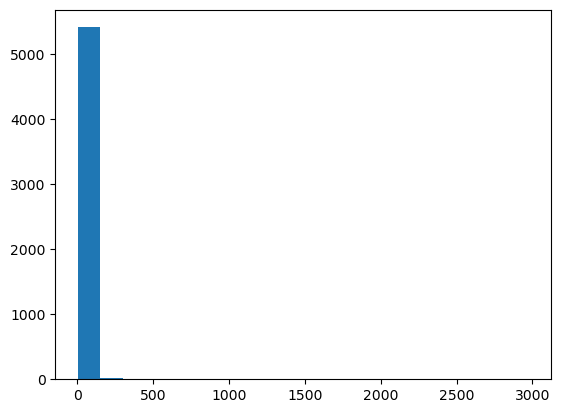

In [43]:
plt.hist(communities_dist, 20)
plt.show()

#### User Degree

In [ ]:
cypher("""
CALL gds.degree.stream('UserEventGraph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE node:User
RETURN node.id AS user, score AS degree
ORDER BY degree DESC
LIMIT 20
""")


,user,degree
0,82351,3347.0
1,597492,3333.0
2,1764596,3242.0
3,82351,3226.0
4,135593,3135.0
5,135593,3134.0
6,584631,3102.0
7,111471,2923.0
8,583810,2836.0
9,1246174,2805.0


#### User–User Similarity

In [ ]:
cypher("""
CALL gds.degree.stream('UserEventGraph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE 'Event' IN labels(node)        // safer than node:Event
RETURN node.id AS event, score AS degree
ORDER BY degree DESC
LIMIT 20

""")


,event,degree
0,1000000189,1703.0
1,1000000189,1702.0
2,1000000189,1701.0
3,1000000189,1700.0
4,1000000189,1699.0
5,1000000189,1698.0
6,1000000189,1697.0
7,1000000189,1696.0
8,1000000189,1695.0
9,1000000189,1694.0


#### Connected Components

In [ ]:
cypher("""
CALL gds.wcc.stream('UserEventGraph')
YIELD nodeId, componentId
WITH gds.util.asNode(nodeId) AS node, componentId
RETURN componentId,
       count(*) AS members
ORDER BY members DESC
""")

,componentId,members
0,2,27966
1,376,406
2,0,304
3,876,204
4,188,192
...,...,...
5293,46310,2
5294,46312,2
5295,46314,2
5296,46362,2


#### FastRP Embeddings for Users

In [ ]:
cypher("""
CALL gds.fastRP.stream('UserEventGraph', {
  nodeLabels: ['User'],
  embeddingDimension: 64
})
YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) AS u, embedding
RETURN u.id AS user, embedding
LIMIT 20
""")


,user,embedding
0,520812,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,12636,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,973673,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1755591,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1723185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,1062642,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,153002,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,182000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,805304,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,788071,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Node Label Degree Stats

In [ ]:
cypher("""
CALL gds.degree.stream('UserEventGraph')
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS n, score
WITH labels(n)[0] AS label, score
RETURN label,
       avg(score) AS avg_degree,
       max(score) AS max_degree,
       min(score) AS min_degree
""")


,label,avg_degree,max_degree,min_degree
0,User,178.658169,3347.0,1.0
1,Event,178.658169,1703.0,1.0
